# PyDMD

## Tutorial 4: Compressed Dynamic Mode Decomposition

In this tutorial we will show the analysis and the reconstruction of a generic system using the compressed dynamic mode decomposition (CDMD). As a reference please follow [this work](https://doi.org/10.1007/s11554-016-0655-2) by Erichson, Brunton and Kutz. In this variation of the original algorithm, the snapshots matrix is compressed through a premultiplication by a proper matrix, and then the compressed matrix is decomposed.

First of all we import the CDMD and the DMD classes from the pydmd package, we set matplotlib for the notebook, we import numpy and we import the time package for some future benchmarks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from pydmd import CDMD
from pydmd import DMD

Now, we create an helper function that returns the input snapshots from a given spatial and temporal resolution.
As in previous tutorials, the studied system is obtained from the sum of different functions:<br>
- $f_1(x, t) = e^{\frac{-x^2}{5}}\,\cos(4x)\,e^{(2.3i)t}$
- $f_2(x, t) = (1-e^{1-\frac{x^2}{6}})e^{(1.3i)t}$
- $f_3(x, t) = (-\frac{x^2}{50} + 1)1.1i^{-2t}$

In [2]:
def create_dataset(x_dim, t_dim):
    def f1(x,t): 
        return np.exp(-x**2*.2)*np.cos(4*x)*np.exp(2.3j*t)

    def f2(x,t):
        return (1-np.exp(1-x**2/6)) * np.exp(1.3j*t)

    def f3(x, t):
        return (-.02*x**2 + 1) * (1.1j**(-2*t))

    x = np.linspace(-5, 5, x_dim)
    t = np.linspace(0, 4*np.pi, t_dim)

    xgrid, tgrid = np.meshgrid(x,t)

    X1 = f1(xgrid, tgrid)
    X2 = f2(xgrid, tgrid)
    X3 = f3(xgrid, tgrid)
    return xgrid, tgrid, (X1 + X2 + X3)

The plot below represents the dataset.

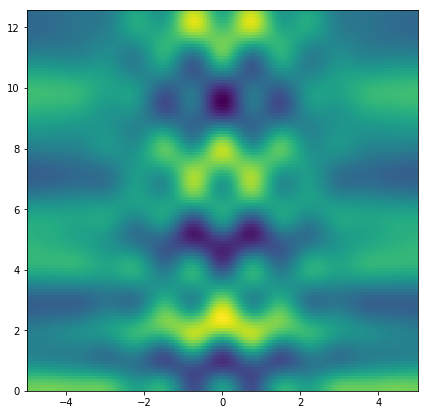

In [3]:
xgrid, tgrid, X = create_dataset(256, 128)
plt.figure(figsize=(7, 7))
plt.pcolor(xgrid, tgrid, X.real)
plt.show()

In order to compress the dataset, we need to build the matrix that premultiplies the snapshots matrix. The class `CDMD` provides the following prebuilt matrices:
- *normal*: a matrix with dimension (`nsnaps`, `ndim`) where the elements are randomly generated with normal distribution with mean equal to 0.0 and standard deviation equal to 1.0;
- *uniform*: a matrix with dimension (`nsnaps`, `ndim`) where the elements are randomly generated with uniform distribution between 0 and 1;
- *sparse*: a random sparse matrix with dimension (`nsnaps`, `ndim`);
- *sample*: a matrix with dimension (`nsnaps`, `ndim`) where each row contains an element equal to 1 and all the other elements are null.

It is sufficient to pass the right string when the new object is created to choose the matrix. Otherwise it is possible to use a custom matrix for the compression, as we show below.

In [4]:
snapshots_matrix = X.T
random_matrix = np.random.permutation(snapshots_matrix.shape[0] * snapshots_matrix.shape[1])
random_matrix = random_matrix.reshape(snapshots_matrix.shape[1], snapshots_matrix.shape[0])

compression_matrix = random_matrix / np.linalg.norm(random_matrix)

We instantiate the `CDMD` matrix, passing as `compression_matrix` argument the matrix we created. The constructor is very similar to the `DMD` class, except to the compression matrix and the missing of the `exact` argument (in the compressed version, there is only one way to compute the modes). We plot the modes and the dynamics.

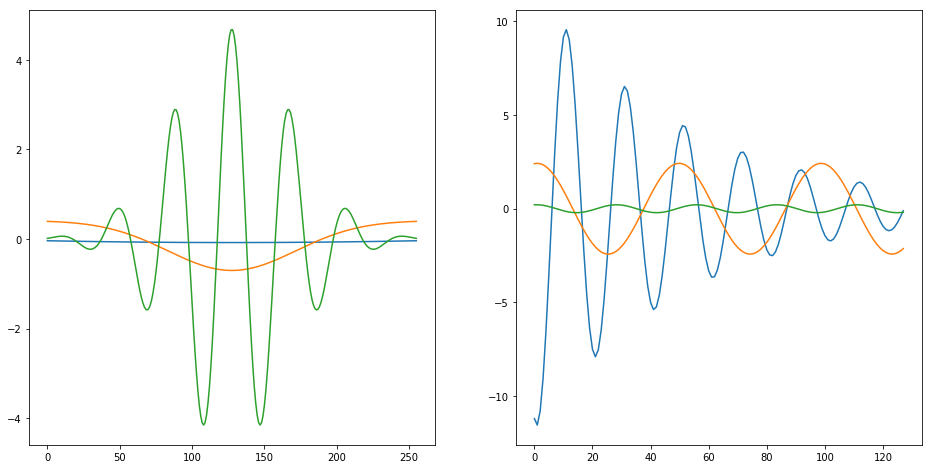

In [5]:
cdmd = CDMD(svd_rank=3, compression_matrix=compression_matrix)
cdmd.fit(snapshots_matrix)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(cdmd.modes.real)
plt.subplot(1, 2, 2)
plt.plot(cdmd.dynamics.T.real)
plt.show()

In order to investigate about the reconstruction accuracy, we compare the results obtained with the CDMD and the standard DMD, respectively.

DMD error: 1.30651710102e-11
CDMD error: 7.44066186383e-12


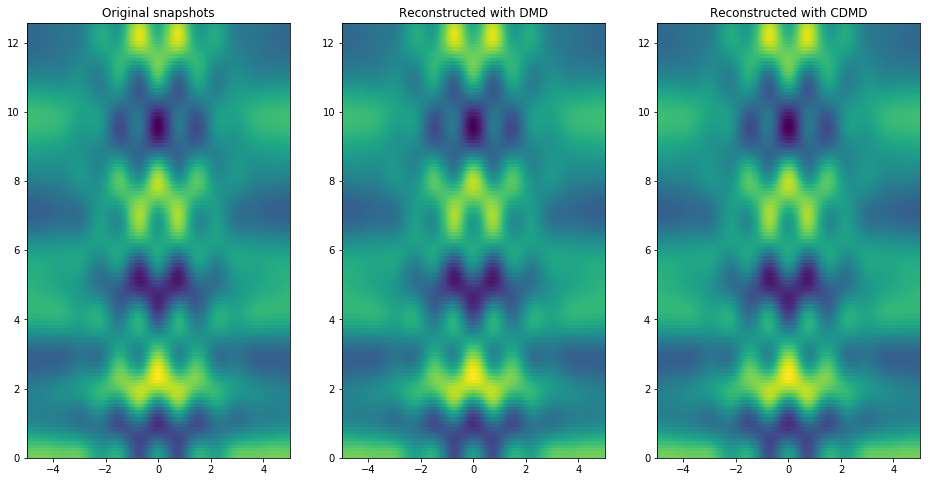

In [6]:
dmd = DMD(svd_rank=3, exact=True)
dmd.fit(snapshots_matrix)

dmd_error = np.linalg.norm(snapshots_matrix-dmd.reconstructed_data)
cdmd_error = np.linalg.norm(snapshots_matrix-cdmd.reconstructed_data)
print("DMD error: {}".format(dmd_error))
print("CDMD error: {}".format(cdmd_error))

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.title('Original snapshots')
plt.pcolor(xgrid, tgrid, snapshots_matrix.real.T)
plt.subplot(1, 3, 2)
plt.title('Reconstructed with DMD')
plt.pcolor(xgrid, tgrid, dmd.reconstructed_data.real.T)
plt.subplot(1, 3, 3)
plt.title('Reconstructed with CDMD')
plt.pcolor(xgrid, tgrid, cdmd.reconstructed_data.real.T)
plt.show()

The error using the compressed input is slightly greater, but the reconstruction looks very similar to the orignal input. So, why we need the compressed algorithm instead of the original one? The snapshots matrix without compression has dimension *ndim $\times$ nsnapshots*, where *ndim* is the dimension of each snapshots and *nsnapshots* is the number of snapshots. The compressed snapshots matrix is instead a *nsnapshots $\times$ nsnapshots* matrix; so, over a userful noise reduction due to the compression, this version allows a faster computation. Let's measure it.

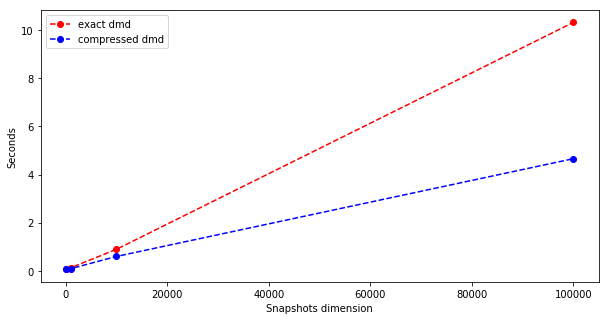

In [7]:
time_dmd = []
time_cdmd = []
dim = []

niter = 4
ndims = 10 ** np.arange(2, 2+niter)
nsnaps = [100] * niter
for nsnap, ndim in zip(nsnaps, ndims):
    snapshots_matrix = create_dataset(ndim, nsnap)[-1].T
    dim.append(snapshots_matrix.shape[0])
    random_matrix = np.random.permutation(snapshots_matrix.shape[0] * snapshots_matrix.shape[1])
    random_matrix = random_matrix.reshape(snapshots_matrix.shape[1], snapshots_matrix.shape[0])

    compression_matrix = random_matrix / np.linalg.norm(random_matrix)
    
    t0 = time.time()
    DMD(svd_rank=-1, exact=True).fit(snapshots_matrix)
    t1 = time.time()
    time_dmd.append(t1-t0)
    
    t0 = time.time()
    CDMD(svd_rank=-1, compression_matrix=compression_matrix).fit(snapshots_matrix)
    t1 = time.time()
    time_cdmd.append(t1-t0)

plt.figure(figsize=(10,5))
plt.plot(dim, time_dmd, 'ro--', label='exact dmd')
plt.plot(dim, time_cdmd, 'bo--', label='compressed dmd')
plt.legend()
plt.ylabel('Seconds')
plt.xlabel('Snapshots dimension')
plt.show()

The input compression, in this case, halves the computational time, with just a negligible quality loss. Try this technique with your biggest datasets and share with us your results! 